In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

# 讀取資料

In [2]:
S4b_train = np.load('S4b_train.npz')
X11b_train = np.load('X11b_train.npz')
S4b_test = np.load('S4b_test.npz')
X11b_test = np.load('X11b_test.npz')

train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

train_label = train_label - 1
test_label = test_label -1
train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

mask = np.where(np.isnan(train_data))
train_data[mask] = np.nanmean(train_data)

mask = np.where(np.isnan(test_data))
test_data[mask] = np.nanmean(test_data)

In [3]:
X_train = torch.from_numpy(train_data).float()
y_train = torch.from_numpy(train_label).float()

X_test = torch.from_numpy(test_data).float()
y_test = torch.from_numpy(test_label).float()

In [4]:
print ("Example of dataset: ")
print ("\n")
print (train_data[0])

Example of dataset: 


[[[ 5.48605805  4.4517016   4.09471132 ... -0.91535741 -3.20223105
   -1.53627641]
  [ 5.52571777  4.45307401  4.84520693 ... -6.9935455  -5.60505926
   -1.15580007]]]


In [5]:
print (str(len(train_data))+" trials / "+str(len(train_data[0]))+\
       " person / "+str(len(train_data[0][0]))+" hands / "+str(len(train_data[0][0][0]))+" with values")


1080 trials / 1 person / 2 hands / 750 with values


# EEGNet with ELU

In [6]:
class EEGNet_ELU(nn.Module):
    def __init__(self):
        super(EEGNet_ELU, self).__init__()
        # Layer 1 
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1),padding = (0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1 , affine=True, track_running_stats=True))
        
        # Layer 2
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4),padding=0),
            nn.Dropout(p=0.25))
        
        # Layer 3
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1,8), padding=0),
            nn.Dropout(p=0.25))
        
        # FC Layer
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=1, bias=True),
            )
        

    def forward(self, x):
        # Layer 1
        x = self.firstconv(x)
        # Layer 2
        x = self.depthwiseConv(x)
        # Layer 3
        x = self.separableConv(x)
        
        # FC Layer
        x = x.view(x.size(0),-1)
        x = self.classify(x)
            
        return x
    
    
net_ELU = EEGNet_ELU()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_ELU.parameters(), lr=1e-2)

# EEGNet with ReLU

In [7]:
class EEGNet_ReLU(nn.Module):
    def __init__(self):
        super(EEGNet_ReLU, self).__init__()
        # Layer 1 
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1),padding = (0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1 , affine=True, track_running_stats=True))
        
        # Layer 2
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4),padding=0),
            nn.Dropout(p=0.25))
        
        # Layer 3
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1,8), padding=0),
            nn.Dropout(p=0.25))
        
        # FC Layer
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=1, bias=True),
            )
        

    def forward(self, x):
        # Layer 1
        x = self.firstconv(x)
        # Layer 2
        x = self.depthwiseConv(x)
        # Layer 3
        x = self.separableConv(x)
        
        # FC Layer
        x = x.view(x.size(0),-1)
        x = self.classify(x)
            
        return x
    
    
net_ReLU = EEGNet_ReLU()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_ReLU.parameters(), lr=1e-2)

# EEGNet with LeakyReLU

In [8]:
class EEGNet_LeakyReLU(nn.Module):
    def __init__(self):
        super(EEGNet_LeakyReLU, self).__init__()
        # Layer 1 
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1),padding = (0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1 , affine=True, track_running_stats=True))
        
        # Layer 2
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4),padding=0),
            #每條NN會0.25機率變0
            nn.Dropout(p=0.25))
        
        # Layer 3
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1,8), padding=0),
            nn.Dropout(p=0.25))
        
        # FC Layer
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=1, bias=True),
            )
        

    def forward(self, x):
        # Layer 1
        x = self.firstconv(x)
        # Layer 2
        x = self.depthwiseConv(x)
        # Layer 3
        x = self.separableConv(x)
        
        # FC Layer
        x = x.view(x.size(0),-1)
        x = self.classify(x)
            
        return x
    
    
net_LeakyReLU = EEGNet_LeakyReLU()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_LeakyReLU.parameters(), lr=1e-2)

In [9]:
def backward(net, x, y):
        running_loss = 0.0
        batch_size = 32
        for i in range(int(len(x)/batch_size)):
            s = i * batch_size
            e = i * batch_size + batch_size

            inputs = x[s:e]
            labels = y[s:e]


            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = nn.MSELoss()

            output = loss(outputs, labels)
            output.backward()

            optimizer.step()

            running_loss = running_loss + output.data
        
        return net.forward(x)
            
def train(net, x, y):
        backward(net, x, y)
        outputs = backward(net, x, y)
        return outputs
    

# 訓練model (ReLU) train data

In [10]:
relu_epoch_result_to_plot = []
relu_acc_result_to_plot_train = []
for epoch in range(11):  # loop over the dataset multiple times
            
        result = train(net_ReLU,X_train,y_train)
        
        if epoch%1 == 0:
            print ("Epoch is: ", epoch)
            relu_epoch_result_to_plot.append(epoch)
            ACC = accuracy_score(y_train, np.round(result.data))
            print ("ACC is: ", ACC)
            relu_acc_result_to_plot_train.append(ACC)

Epoch is:  0
ACC is:  0.4981481481481482
Epoch is:  1
ACC is:  0.49722222222222223
Epoch is:  2
ACC is:  0.5018518518518519
Epoch is:  3
ACC is:  0.5027777777777778
Epoch is:  4
ACC is:  0.49537037037037035
Epoch is:  5
ACC is:  0.49537037037037035
Epoch is:  6
ACC is:  0.49166666666666664
Epoch is:  7
ACC is:  0.4981481481481482
Epoch is:  8
ACC is:  0.49722222222222223
Epoch is:  9
ACC is:  0.4935185185185185
Epoch is:  10
ACC is:  0.4888888888888889


# 訓練model (ReLU) test data

In [11]:
relu_epoch_result_to_plot = []
relu_acc_result_to_plot = []
for epoch in range(11):  # loop over the dataset multiple times
            
        result = train(net_ReLU,X_test,y_test)
        
        if epoch%1 == 0:
            print ("Epoch is: ", epoch)
            relu_epoch_result_to_plot.append(epoch)
            ACC = accuracy_score(y_test, np.round(result.data))
            print ("ACC is: ", ACC)
            relu_acc_result_to_plot.append(ACC)

Epoch is:  0
ACC is:  0.49074074074074076
Epoch is:  1
ACC is:  0.5009259259259259
Epoch is:  2
ACC is:  0.4981481481481482
Epoch is:  3
ACC is:  0.5037037037037037
Epoch is:  4
ACC is:  0.49074074074074076
Epoch is:  5
ACC is:  0.5027777777777778
Epoch is:  6
ACC is:  0.5027777777777778
Epoch is:  7
ACC is:  0.5055555555555555
Epoch is:  8
ACC is:  0.5092592592592593
Epoch is:  9
ACC is:  0.49537037037037035
Epoch is:  10
ACC is:  0.49074074074074076


# 訓練model (LeakyReLU) train data

In [12]:
leakyrelu_epoch_result_to_plot = []
leakyrelu_acc_result_to_plot_train = []
for epoch in range(11):  # loop over the dataset multiple times
            
        result = train(net_LeakyReLU,X_train,y_train)
        
        if epoch%1 == 0:
            print ("Epoch is: ", epoch)
            leakyrelu_epoch_result_to_plot.append(epoch)
            ACC = accuracy_score(y_train, np.round(result.data))
            print ("ACC is: ", ACC)
            leakyrelu_acc_result_to_plot_train.append(ACC)

Epoch is:  0
ACC is:  0.49166666666666664
Epoch is:  1
ACC is:  0.46944444444444444
Epoch is:  2
ACC is:  0.5009259259259259
Epoch is:  3
ACC is:  0.48703703703703705
Epoch is:  4
ACC is:  0.4935185185185185
Epoch is:  5
ACC is:  0.5203703703703704
Epoch is:  6
ACC is:  0.5259259259259259
Epoch is:  7
ACC is:  0.5185185185185185
Epoch is:  8
ACC is:  0.5148148148148148
Epoch is:  9
ACC is:  0.5018518518518519
Epoch is:  10
ACC is:  0.5148148148148148


# 訓練model (LeakyReLU) test data

In [13]:
leakyrelu_epoch_result_to_plot = []
leakyrelu_acc_result_to_plot = []
for epoch in range(11):  # loop over the dataset multiple times
            
        result = train(net_LeakyReLU,X_test,y_test)
        
        if epoch%1 == 0:
            print ("Epoch is: ", epoch)
            leakyrelu_epoch_result_to_plot.append(epoch)
            ACC = accuracy_score(y_test, np.round(result.data))
            print ("ACC is: ", ACC)
            leakyrelu_acc_result_to_plot.append(ACC)

Epoch is:  0
ACC is:  0.562037037037037
Epoch is:  1
ACC is:  0.5777777777777777
Epoch is:  2
ACC is:  0.5685185185185185
Epoch is:  3
ACC is:  0.5333333333333333
Epoch is:  4
ACC is:  0.5611111111111111
Epoch is:  5
ACC is:  0.562962962962963
Epoch is:  6
ACC is:  0.5296296296296297
Epoch is:  7
ACC is:  0.5546296296296296
Epoch is:  8
ACC is:  0.5444444444444444
Epoch is:  9
ACC is:  0.55
Epoch is:  10
ACC is:  0.5333333333333333


# 訓練model (ELU) train data

In [14]:
elu_epoch_result_to_plot = []
elu_acc_result_to_plot_train = []
for epoch in range(11):  # loop over the dataset multiple times
            
        result = train(net_ELU,X_train,y_train)
        
        if epoch%1 == 0:
            print ("Epoch is: ", epoch)
            elu_epoch_result_to_plot.append(epoch)
            ACC = accuracy_score(y_train, np.round(result.data))
            print ("ACC is: ", ACC)
            elu_acc_result_to_plot_train.append(ACC)

Epoch is:  0
ACC is:  0.5009259259259259
Epoch is:  1
ACC is:  0.5009259259259259
Epoch is:  2
ACC is:  0.5009259259259259
Epoch is:  3
ACC is:  0.49907407407407406
Epoch is:  4
ACC is:  0.49907407407407406
Epoch is:  5
ACC is:  0.5
Epoch is:  6
ACC is:  0.4981481481481482
Epoch is:  7
ACC is:  0.49907407407407406
Epoch is:  8
ACC is:  0.4981481481481482
Epoch is:  9
ACC is:  0.5
Epoch is:  10
ACC is:  0.4962962962962963


# 訓練model (ELU) test data

In [15]:
elu_epoch_result_to_plot = []
elu_acc_result_to_plot = []
for epoch in range(11):  # loop over the dataset multiple times
            
        result = train(net_ELU,X_test,y_test)
        
        if epoch%1 == 0:
            print ("Epoch is: ", epoch)
            elu_epoch_result_to_plot.append(epoch)
            ACC = accuracy_score(y_test, np.round(result.data))
            print ("ACC is: ", ACC)
            elu_acc_result_to_plot.append(ACC)

Epoch is:  0
ACC is:  0.49722222222222223
Epoch is:  1
ACC is:  0.49722222222222223
Epoch is:  2
ACC is:  0.5
Epoch is:  3
ACC is:  0.4981481481481482
Epoch is:  4
ACC is:  0.5
Epoch is:  5
ACC is:  0.49907407407407406
Epoch is:  6
ACC is:  0.49722222222222223
Epoch is:  7
ACC is:  0.49907407407407406
Epoch is:  8
ACC is:  0.4981481481481482
Epoch is:  9
ACC is:  0.4962962962962963
Epoch is:  10
ACC is:  0.5


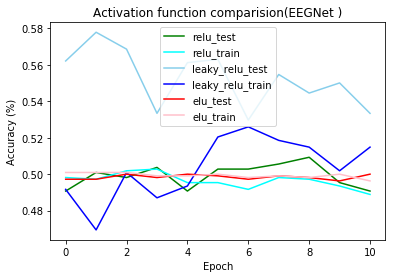

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.title('Activation function comparision(EEGNet )')
plt.plot(relu_epoch_result_to_plot, relu_acc_result_to_plot, color='green', label='relu_test')
plt.plot(relu_epoch_result_to_plot, relu_acc_result_to_plot_train, color='cyan', label='relu_train')
plt.plot(leakyrelu_epoch_result_to_plot, leakyrelu_acc_result_to_plot,  color='skyblue', label='leaky_relu_test')
plt.plot(leakyrelu_epoch_result_to_plot, leakyrelu_acc_result_to_plot_train,  color='blue', label='leaky_relu_train')
plt.plot(elu_epoch_result_to_plot, elu_acc_result_to_plot, color='red', label='elu_test')
plt.plot(elu_epoch_result_to_plot, elu_acc_result_to_plot_train, color='pink', label='elu_train')

plt.legend() 

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()
